In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import joblib
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')

from ml_editor.data_processing import (
    format_raw_df,
    get_split_by_author
)
from ml_editor.model_v2 import (
    add_char_count_features,
    get_word_stats,
    get_sentiment_score,
    POS_NAMES,
    get_question_score_from_input
)
from ml_editor.model_evaluation import (
    get_feature_importance,
    get_roc_plot,
    get_confusion_matrix_plot,
    get_calibration_plot
)
%load_ext autoreload
%autoreload 2
np.random.seed(35)

data_path = Path('../data/writers.csv')
df = pd.read_csv(data_path)
df = format_raw_df(df.copy())

df = df.loc[df["is_question"]].copy()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dydgh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df["full_text"] = df["Title"].str.cat(df["body_text"], sep=" ", na_rep="")
df = add_char_count_features(df.copy())
df = get_word_stats(df.copy())
df = get_sentiment_score(df.copy())

100%|█████████████████████████████████████████████████████████████████████████████| 7971/7971 [00:29<00:00, 274.69it/s]


In [3]:
feature_arr = ["num_questions", 
               "num_periods",
               "num_commas",
               "num_exclam",
               "num_quotes",
               "num_colon",
               "num_stops",
               "num_semicolon",
               "num_words",
               "num_chars",
               "num_diff_words",
               "avg_word_len",
               "polarity"
              ]
feature_arr.extend(POS_NAMES.keys())

In [4]:
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=40)

In [5]:
df[feature_arr].head()*100

,num_questions,num_periods,num_commas,num_exclam,num_quotes,num_colon,num_stops,num_semicolon,num_words,num_chars,...,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X
Id,,,,,,,,,,,,,,,,,,,,,
1,56.818182,56.818182,28.409091,0.0,0.000000,0.0,1022.727273,0.0,2073.863636,35200,...,3.409091,0.000000,1.136364,2.272727,0.000000,1.988636,0.568182,0.000000,3.409091,0.0
2,90.634441,30.211480,60.422961,0.0,60.422961,0.0,1087.613293,0.0,2024.169184,33100,...,4.531722,0.000000,0.000000,1.510574,0.000000,2.416918,0.302115,0.000000,0.906344,0.0
3,175.438596,87.719298,87.719298,0.0,0.000000,0.0,1491.228070,0.0,2719.298246,11400,...,2.631579,0.877193,0.000000,6.140351,0.000000,3.508772,1.754386,0.000000,5.263158,0.0
5,70.257611,46.838407,117.096019,0.0,0.000000,0.0,843.091335,0.0,2154.566745,42700,...,3.747073,0.000000,1.170960,0.936768,0.000000,2.810304,0.468384,0.234192,3.512881,0.0
7,135.135135,67.567568,67.567568,0.0,0.000000,0.0,945.945946,0.0,2027.027027,14800,...,2.702703,0.000000,0.000000,2.702703,1.351351,2.702703,0.675676,0.000000,1.351351,0.0


In [6]:
def get_feature_vector_and_label(df, feature_names):
    """
    벡터 특성과 특성 이름으로 입력과 출력 벡터를 생성합니다.
    :param df: 입력 DataFrame
    :param feature_names: (벡터가 아닌) 특성 열의 이름 
    :return: 특성 배열과 레이블 배열
    """
    features = df[feature_names].astype(float)
    labels = df["Score"] > df["Score"].median()
    return features, labels

X_train, y_train = get_feature_vector_and_label(train_df, feature_arr)
X_test, y_test = get_feature_vector_and_label(test_df, feature_arr)

In [7]:
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', oob_score=True)
clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)
y_predicted_proba = clf.predict_proba(X_test)

In [8]:
def get_metrics(y_test, y_predicted):  
    # 진짜 양성 / (진짜 양성 + 가짜 양성)
    precision = precision_score(y_test, y_predicted, pos_label=True,
                                    average='binary')             
    # 진짜 양성 / (진짜 양성 + 가짜 음성)
    recall = recall_score(y_test, y_predicted, pos_label=True,
                              average='binary')
    
    # 정밀도와 재현율의 조화 평균
    f1 = f1_score(y_test, y_predicted, pos_label=True, average='binary')
    
    # 진짜 양성 + 진짜 음성 / 전체
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1


# 훈련 정확도
# https://datascience.stackexchange.com/questions/13151/randomforestclassifier-oob-scoring-method 참조
y_train_pred = np.argmax(clf.oob_decision_function_,axis=1)

accuracy, precision, recall, f1 = get_metrics(y_train, y_train_pred)
print("훈련 정확도 = %.3f, 정밀도 = %.3f, 재현율 = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

훈련 정확도 = 0.582, 정밀도 = 0.556, 재현율 = 0.443, f1 = 0.493


In [9]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
print("검증 정확도 = %.3f, 정밀도 = %.3f, 재현율 = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

검증 정확도 = 0.580, 정밀도 = 0.592, 재현율 = 0.456, f1 = 0.515


In [10]:
model_path = Path("../models/model_3.pkl")
joblib.dump(clf, model_path) 

['..\\models\\model_3.pkl']

In [11]:
all_feature_names = np.array(feature_arr)
k = 20
print("상위 %s개 중요도:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, all_feature_names)[:k]]))

print("\n하위 %s개 중요도:\n" % k)
print('\n'.join(["%s: %.2g" % (tup[0], tup[1]) for tup in get_feature_importance(clf, all_feature_names)[-k:]]))

상위 20개 중요도:

num_chars: 0.05
num_questions: 0.048
num_periods: 0.047
AUX: 0.045
ADJ: 0.045
num_diff_words: 0.044
DET: 0.044
NOUN: 0.044
ADV: 0.044
ADP: 0.043
PUNCT: 0.042
SCONJ: 0.041
PRON: 0.041
num_commas: 0.04
num_stops: 0.04
PART: 0.04
polarity: 0.039
num_words: 0.039
VERB: 0.039
avg_word_len: 0.037

하위 20개 중요도:

PUNCT: 0.042
SCONJ: 0.041
PRON: 0.041
num_commas: 0.04
num_stops: 0.04
PART: 0.04
polarity: 0.039
num_words: 0.039
VERB: 0.039
avg_word_len: 0.037
PROPN: 0.032
NUM: 0.025
num_colon: 0.021
num_quotes: 0.019
SYM: 0.013
X: 0.012
INTJ: 0.011
num_semicolon: 0.007
num_exclam: 0.007
CONJ: 0


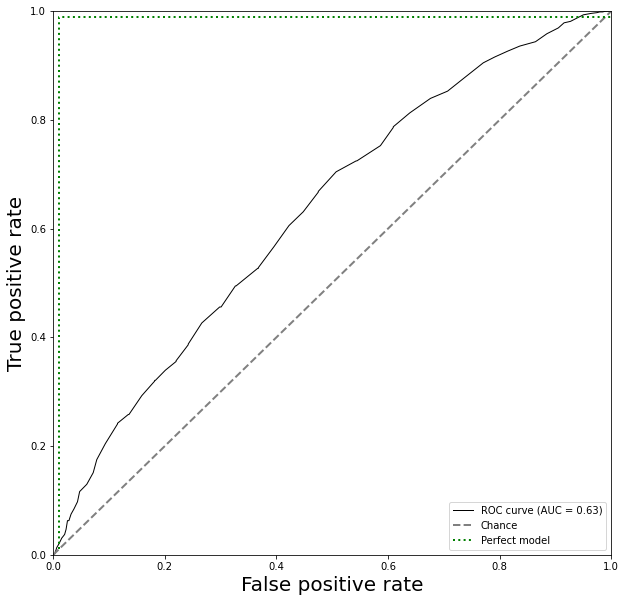

In [12]:
get_roc_plot(y_predicted_proba[:,1], y_test, figsize=(10,10))

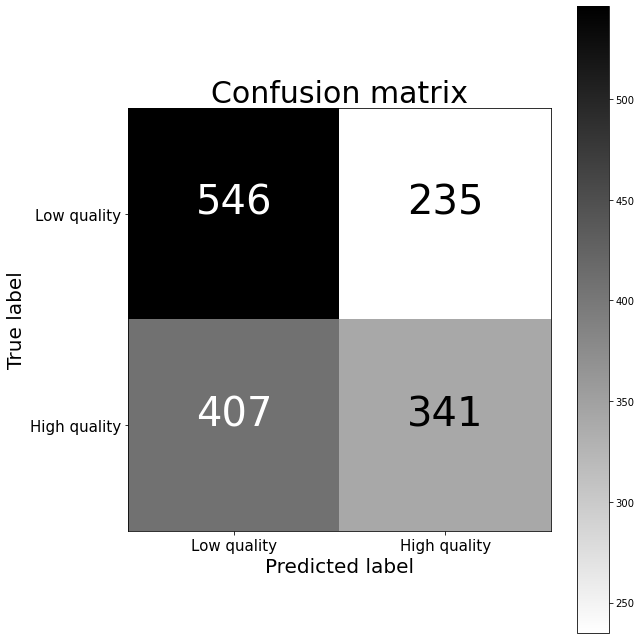

In [13]:
get_confusion_matrix_plot(y_predicted, y_test, figsize=(9, 9))

No handles with labels found to put in legend.


	Brier: 0.237


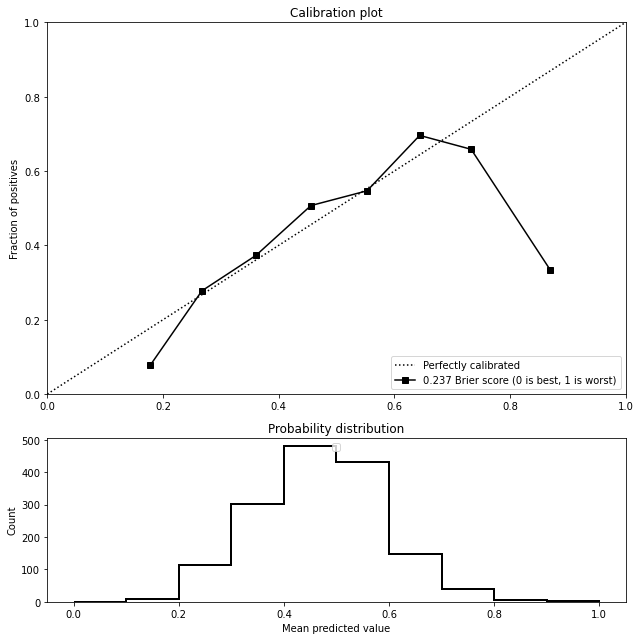

In [14]:
get_calibration_plot(y_predicted_proba[:,1], y_test, figsize=(9,9))

In [15]:
pos_prob = get_question_score_from_input("""
When quoting a person's informal speech, how much liberty do you have to make changes to what they say?
""")

print("%s probability of the question receiving a high score according to our model" % (pos_prob))

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 466.76it/s]

0.4 probability of the question receiving a high score according to our model
